In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast


In [161]:
# Load data
edge_list = pd.read_csv('../02_data/train_test/edge_list.csv')
train_data = pd.read_csv('../02_data/train_test/train_data.csv')
train_data = pd.read_csv('../02_data/train_test/train_data.csv')

In [162]:
train_data

,domain_index,article_embedding,virality,year
0,1420,[-3.62667615e-02 7.58439199e-02 -2.61213667e-...,0.945806,0.843444
1,3697,[ 0.08478758 -0.10553251 -0.04569786 -0.162647...,0.697707,0.857143
2,2636,[-0.00871386 0.01925436 -0.04681226 -0.048136...,0.687671,0.920029
3,5049,[-2.87912979e-02 5.65173118e-02 -4.86887201e-...,0.828178,0.801681
4,1292,[ 5.50025127e-02 8.52471845e-03 -3.31000386e-...,0.867542,0.829221
...,...,...,...,...
6107,5873,[-3.80244223e-02 5.53963154e-02 6.77183802e-...,0.831007,0.799899
6108,153,[ 0.01009611 0.03097114 -0.12901936 -0.034202...,1.000000,1.000000
6109,978,[ 0.03894909 -0.11853513 -0.31919676 -0.145071...,0.697707,0.714286
6110,1032,[-7.06026978e-02 2.07726051e-01 -6.87203143e-...,0.986915,0.974824


In [111]:
# Add missing columns: label and domain_index
train_data['label'] = (train_data['pc1'] > 0.5).astype(int)
if 'domain_index' not in train_data.columns:
    domain_mapping = {domain: idx for idx, domain in enumerate(train_data['domain'].unique())}
    train_data['domain_index'] = train_data['domain'].map(domain_mapping)

# Ensure edge_list indices are within bounds
max_node_index = len(train_data) - 1
edge_list = edge_list[(edge_list['chat_id'] <= max_node_index) & (edge_list['domain_index'] <= max_node_index)]

# Split train_data into train and validation sets
train_domains, val_domains = train_test_split(train_data['domain_index'], test_size=0.2, random_state=42)


In [153]:
import numpy as np
import re

def preprocess_embedding(emb):
    """
    Preprocess and clean embedding values. Handles cases where:
    - The embedding is a string (requires cleaning and parsing).
    - The embedding is already a numpy array (no further processing needed).

    Args:
        emb: Embedding data (string or numpy array).

    Returns:
        np.array: Cleaned numpy array of embeddings.

    Raises:
        ValueError: If the data cannot be cleaned or converted.
    """
    # If it's already a numpy array, return as is
    if isinstance(emb, np.ndarray):
        return emb

    # If it's a list or other iterable, convert it to a numpy array
    if isinstance(emb, (list, tuple)):
        return np.array(emb, dtype=np.float32)

    # If it's a string, clean and parse
    if isinstance(emb, str):
        try:
            # Fix missing commas using regex
            emb = re.sub(r'(?<=\d)\s+(?=\d|\-)', ',', emb)
            # Ensure it is wrapped in brackets
            if not emb.startswith("["):
                emb = "[" + emb
            if not emb.endswith("]"):
                emb = emb + "]"
            # Evaluate the cleaned string and convert to numpy array
            parsed_emb = eval(emb)  # Using eval since we sanitize the string
            return np.array(parsed_emb, dtype=np.float32)
        except Exception as e:
            raise ValueError(f"Failed to process embedding: {emb}. Error: {e}")

    # If none of the above, raise an error
    raise ValueError(f"Unsupported embedding format: {type(emb)}")


In [158]:
train_data['article_embedding'] = train_data['article_embedding'].apply(preprocess_embedding)

In [159]:
import torch
import numpy as np

def preprocess_train_data(train_data):
    """
    Combines multiple features into a single tensor for graph node features.
    
    Args:
        train_data (DataFrame): DataFrame containing the features:
            - 'article_embedding': preprocessed numpy arrays
            - 'virality': numeric
            - 'chats': numeric
            - 'messages': numeric
            - 'year': numeric
    
    Returns:
        torch.Tensor: Combined tensor of node features.
    """
    # Ensure 'article_embedding' is preprocessed
    embeddings = np.vstack(train_data['article_embedding'].values)

    # Extract other features and convert them to numpy arrays
    other_features = train_data[['virality', 'chats', 'messages', 'year']].to_numpy(dtype=np.float32)

    # Combine article embeddings with the other features
    combined_features = np.hstack((embeddings, other_features))

    # Convert to torch tensor
    return torch.tensor(combined_features, dtype=torch.float)


In [160]:
def prepare_graph_data(train_data, edge_list):
    # Combine node features into a single tensor
    x = preprocess_train_data(train_data)
    
    # Prepare edge indices
    edge_index = torch.tensor(edge_list.values.T, dtype=torch.long)
    
    # Prepare labels (if available)
    y = torch.tensor(train_data['label'].values, dtype=torch.long) if 'label' in train_data else None

    return Data(x=x, edge_index=edge_index, y=y)

# Prepare the graph data
data = prepare_graph_data(train_data, edge_list)


KeyError: "['chats', 'messages'] not in index"

In [143]:
# Prepare graph data
def prepare_graph_data(train_data, edge_list):
    x = torch.tensor(np.vstack(train_data['article_embedding'].values), dtype=torch.float)
    # x = torch.tensor(np.vstack(train_data['article_embedding'].apply(lambda emb: np.array(ast.literal_eval(emb))).values), dtype=torch.float)
    edge_index = torch.tensor(edge_list.values.T, dtype=torch.long)
    y = torch.tensor(train_data['label'].values, dtype=torch.long) if 'label' in train_data else None
    return Data(x=x, edge_index=edge_index, y=y)

data = prepare_graph_data(train_data, edge_list)



In [112]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6112 entries, 0 to 6111
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   domain             6112 non-null   object 
 1   article_embedding  6112 non-null   object 
 2   messages           6112 non-null   int64  
 3   chats              6112 non-null   int64  
 4   virality           6112 non-null   float64
 5   year               6112 non-null   float64
 6   pc1                6112 non-null   float64
 7   message_embedding  6112 non-null   object 
 8   label              6112 non-null   int64  
 9   domain_index       6112 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 477.6+ KB


In [144]:
# Prepare graph data
def prepare_graph_data(train_data, edge_list, train_domains, val_domains):
    x = torch.tensor(train_data[['article_embedding', 'virality', 'chats', 'messages', 'year']].values, dtype=torch.float)
    edge_index = torch.tensor(edge_list.values.T, dtype=torch.long)
    y = torch.tensor(train_data['label'].values, dtype=torch.long)

    train_mask = torch.tensor(train_data['domain_index'].isin(train_domains).values, dtype=torch.bool)
    val_mask = torch.tensor(train_data['domain_index'].isin(val_domains).values, dtype=torch.bool)
    test_mask = torch.tensor(train_data['domain_index'].isin(test_data['domain_index']).values, dtype=torch.bool)

    return Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

data = prepare_graph_data(train_data, edge_list, train_domains, val_domains)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [114]:
# Define GNN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Model configuration
input_dim = data.x.shape[1]
hidden_dim = 64
output_dim = len(train_data['label'].unique())
model = GCN(input_dim, hidden_dim, output_dim)

# Training configuration
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



In [126]:
# Training loop
train_losses = []
val_losses = []

def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation
def validate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return loss.item()

# Train the model
num_epochs = 500
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, data)
    val_loss = validate(model, data)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 10, Loss: 16.2585, Validation Loss: 36.8182
Epoch 20, Loss: 16.2585, Validation Loss: 30.1443
Epoch 30, Loss: 16.2585, Validation Loss: 25.7826
Epoch 40, Loss: 16.2585, Validation Loss: 35.0109
Epoch 50, Loss: 16.2585, Validation Loss: 16.1508
Epoch 60, Loss: 16.2585, Validation Loss: 10.7898
Epoch 70, Loss: 16.2585, Validation Loss: 37.6310
Epoch 80, Loss: 16.2585, Validation Loss: 21.5029
Epoch 90, Loss: 16.2585, Validation Loss: 22.9626
Epoch 100, Loss: 16.2585, Validation Loss: 12.6322
Epoch 110, Loss: 16.2585, Validation Loss: 4.4453
Epoch 120, Loss: 16.2585, Validation Loss: 4.8130
Epoch 130, Loss: 16.2585, Validation Loss: 9.1536
Epoch 140, Loss: 16.2585, Validation Loss: 6.5905
Epoch 150, Loss: 16.2585, Validation Loss: 12.9487
Epoch 160, Loss: 16.2585, Validation Loss: 4.2004
Epoch 170, Loss: 16.2585, Validation Loss: 11.9578
Epoch 180, Loss: 16.2585, Validation Loss: 10.0067
Epoch 190, Loss: 16.2585, Validation Loss: 13.4523
Epoch 200, Loss: 16.2585, Validation Loss: 16

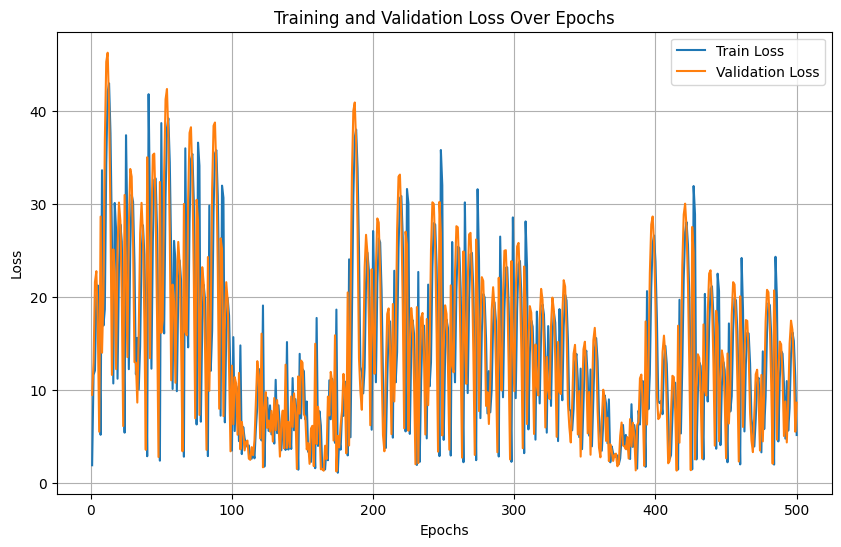

In [127]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [120]:

# Test loop
def test(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[data.test_mask].argmax(dim=1)
        correct = pred.eq(data.y[data.test_mask]).sum().item()
        total = data.test_mask.sum().item()
        accuracy = correct / total
    return accuracy

# Evaluate on test data
test_accuracy = test(model, data)
print(f"Test Accuracy: {test_accuracy:.4f}")

TypeError: GCN.forward() takes 2 positional arguments but 3 were given

In [64]:
import re
import ast

# Function to clean and fix embedding format
def fix_format(x):
    if isinstance(x, str):
        x = re.sub(r'\s+', ',', x.strip())  # Replace spaces with commas
        x = f"[{x}]"  # Ensure proper list syntax
        return ast.literal_eval(x)
    return x

# Apply the cleaning function
train_data['article_embedding'] = train_data['article_embedding'].apply(fix_format)


SyntaxError: invalid syntax (<unknown>, line 1)